#Datathon: Machine Learning project
*by Angela Aguirre*

Importing necessary libraries:

In [1]:
import io
import requests
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn

In [ ]:
import pickle
nombre_archivo = "neuronal_model.pickle"
#Guardar modelo 
pickle.dump(model, open(nombre_archivo, "wb"))
# Cargar modelo guardado
loaded_model = pickle.load(open(nombre_archivo, "rb"))

Importing datasets:

In [2]:
data = requests.get('https://raw.githubusercontent.com/soyHenry/Datathon/main/hospitalizaciones_train.csv').content
evaluation = requests.get('https://raw.githubusercontent.com/soyHenry/Datathon/main/hospitalizaciones_test.csv').content

Visually verifying data:

In [3]:
print("\033[1m ---Data:---\033[0m")
display(data[0:700])
print('\033[1m---Evaluation:---\033[0m')
display(evaluation[0:700])

 ---Data:---


b'Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)\n4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8\n4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9\n2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7\n4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8\n2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34\n2,gynecology,F,Dr Ol'

---Evaluation:---


b'Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit\n3,gynecology,F,Dr Olivia,10,2858,21-30,Female,Trauma,Moderate,Other,2,No,4749.640225\n2,TB & Chest disease,E,Dr John,4,65657,51-60,Female,Trauma,Moderate,Asthama,2,Yes,4122.261324\n2,radiotherapy,E,Dr John,7,45598,51-60,Other,Trauma,Moderate,None,3,No,5459.067882\n2,gynecology,F,Dr Olivia,1,31132,21-30,Female,Trauma,Moderate,None,2,Yes,3987.033318\n2,anesthesia,A,Dr John,7,125021,51-60,Female,Trauma,Extreme,Diabetes,2,No,4770.789695\n4,radiotherapy,E,Dr Sam,10,127273,71-80,Male,Tra'

Load into pandas dataframes:

In [4]:
data_df = pd.read_csv(io.StringIO(data.decode('utf-8')))
evaluation_df = pd.read_csv(io.StringIO(evaluation.decode('utf-8')))

Visualizing dataframes:

In [5]:
print("\033[1m---Train DataFrame: ---\033[0m")
display(data_df.head(2))
print("\033[1m\n---Test DataFrame: ---\033[1m")
display(evaluation_df.head(2))

---Train DataFrame: ---


,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9



---Test DataFrame: ---


,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit
0,3,gynecology,F,Dr Olivia,10,2858,21-30,Female,Trauma,Moderate,Other,2,No,4749.640225
1,2,TB & Chest disease,E,Dr John,4,65657,51-60,Female,Trauma,Moderate,Asthama,2,Yes,4122.261324


Now we take a closer look into data_df dataframe, because this is the one we should train our model with. The dataframe evaluation_df will be used to make predictions and return those results for evaluation

In [6]:
print(data_df.columns)

Index(['Available Extra Rooms in Hospital', 'Department', 'Ward_Facility_Code',
       'doctor_name', 'staff_available', 'patientid', 'Age', 'gender',
       'Type of Admission', 'Severity of Illness', 'health_conditions',
       'Visitors with Patient', 'Insurance', 'Admission_Deposit',
       'Stay (in days)'],
      dtype='object')


The column: `'Available Extra Rooms in Hospital'` doesn't provide relevant information for the purpose of the model, because the recovery time we know isn't influenced by the rooms available in the hospital. This column will be drooped. 

In [7]:
data_df.Department.unique()

array(['gynecology', 'anesthesia', 'TB & Chest disease', 'radiotherapy',
       'surgery'], dtype=object)

The department could be relevant on the time of stay in the hospital, because some treatments could take longer than others. This feature will be kept for the model.

In [8]:
data_df.Ward_Facility_Code.unique()

array(['D', 'B', 'E', 'F', 'A', 'C'], dtype=object)

According to the United Kingdom National Health Service Ward is a group of Hospital Beds with associated treatment facilities managed as a single unit for the purposes of staffing and treatment responsibilities.

This means that the column Ward identifies which unit in the hospital does the patient belong, if the patient belongs to a facility that treats health conditions with more time of recovery it could impact the time of the stay, hence adding information to the model.

This feature will be kept for the model.

https://www.datadictionary.nhs.uk/classes/ward.html

In [9]:
print('\033[1mValues in staff_available:\n\033[0m',data_df.staff_available.unique())
print('\033[1mValues in doctor_name:\n\033[0m',data_df.doctor_name.unique())
print('\033[1mValues in Type of Admission:\n\033[0m',data_df['Type of Admission'].unique())
print('\033[1mValues in Visitors with Patient:\n\033[0m',data_df['Visitors with Patient'].unique())

Values in staff_available:
 [ 0  2  8  7 10  5  9  3  6  4  1]
Values in doctor_name:
 ['Dr Sophia' 'Dr Olivia' 'Dr Mark' 'Dr John' 'Dr Sarah' 'Dr Sam'
 'Dr Nathan' 'Dr Simon' 'Dr Isaac']
Values in Type of Admission:
 ['Trauma' 'Urgent' 'Emergency']
Values in Visitors with Patient:
 [ 4  2  3 11  9  6  8 12  5  1 14  7 13 10 22 18  0 16 20 21 19 23 15 24
 17 30 32 25]


The columns `'Available Extra Rooms in Hospital'` and `'patientid'` don't give significant information to the task at hand as was described before, so these columns will be drooped, and the original dataset will be preserved in case there's need to go back to that version.

Moreover, the remaining columns have information that contributes to the time of stay of the patient in the hospital:

`'Department', 'Ward_Facility_Code', 'doctor_name', 'staff_available','Age', 'gender','Type of Admission', 'Severity of Illness', 'health_conditions','Visitors with Patient', 'Insurance',` and `'Admission_Deposit'`

These changes will be applied to the evaluation dataset as well.

In [10]:
model_data = data_df.drop(columns=['Available Extra Rooms in Hospital','patientid'])
evaluation_data = evaluation_df.drop(columns=['Available Extra Rooms in Hospital','patientid'])

In [11]:
print('\033[1mNulls in model_data:\033[0m\n',model_data.isnull().sum())
print('\n\033[1mNulls in evaluation_data:\033[0m\n',evaluation_data.isnull().sum())

Nulls in model_data:
 Department               0
Ward_Facility_Code       0
doctor_name              0
staff_available          0
Age                      0
gender                   0
Type of Admission        0
Severity of Illness      0
health_conditions        0
Visitors with Patient    0
Insurance                0
Admission_Deposit        0
Stay (in days)           0
dtype: int64

Nulls in evaluation_data:
 Department               0
Ward_Facility_Code       0
doctor_name              0
staff_available          0
Age                      0
gender                   0
Type of Admission        0
Severity of Illness      0
health_conditions        0
Visitors with Patient    0
Insurance                0
Admission_Deposit        0
dtype: int64


We just veryfied there are not nulls in both datasets

In [12]:
display(model_data.describe())

,staff_available,Visitors with Patient,Admission_Deposit,Stay (in days)
count,410000.000000,410000.000000,410000.000000,410000.000000
mean,5.020946,3.552520,4723.419239,12.378193
std,3.158018,2.247459,1047.420292,7.905618
min,0.000000,0.000000,1654.005148,3.000000
25%,2.000000,2.000000,4072.638351,8.000000
50%,5.000000,3.000000,4627.488745,9.000000
75%,8.000000,4.000000,5092.349430,11.000000
max,10.000000,32.000000,10104.726390,51.000000


In [13]:
model_data.shape

(410000, 13)

So, we have 12 columns for the model and 1 column as target

In [14]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Department             410000 non-null  object 
 1   Ward_Facility_Code     410000 non-null  object 
 2   doctor_name            410000 non-null  object 
 3   staff_available        410000 non-null  int64  
 4   Age                    410000 non-null  object 
 5   gender                 410000 non-null  object 
 6   Type of Admission      410000 non-null  object 
 7   Severity of Illness    410000 non-null  object 
 8   health_conditions      410000 non-null  object 
 9   Visitors with Patient  410000 non-null  int64  
 10  Insurance              410000 non-null  object 
 11  Admission_Deposit      410000 non-null  float64
 12  Stay (in days)         410000 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 40.7+ MB


Now, we must get the categorical variables to numeric values, so the model can receive them and make the predictions, because models don't work with strings.
First, I'll create the target column base on the information of the column `'Stay (in days)'`, according with the requirements for this project: a short stay is equal to 8 days or less, and a long stay is greater than 8 days

In [15]:
model_data['target'] = np.where(model_data['Stay (in days)']>8, 1, 0)
display(model_data.head(10))
display(model_data.tail(10))

,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),target
0,gynecology,D,Dr Sophia,0,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8,0
1,gynecology,B,Dr Sophia,2,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9,1
2,gynecology,B,Dr Sophia,8,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7,0
3,gynecology,D,Dr Olivia,7,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8,0
4,anesthesia,E,Dr Mark,10,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34,1
5,gynecology,F,Dr Olivia,2,21-30,Female,Trauma,Moderate,Other,2,Yes,4539.268397,11,1
6,gynecology,D,Dr Olivia,5,31-40,Female,Emergency,Moderate,Other,3,Yes,4669.961786,8,0
7,gynecology,B,Dr Sophia,8,21-30,Female,Emergency,Moderate,Heart disease,3,Yes,5101.675480,7,0
8,TB & Chest disease,A,Dr John,7,31-40,Other,Trauma,Moderate,Other,2,No,4899.767616,12,1
9,gynecology,D,Dr Sarah,7,41-50,Female,Trauma,Extreme,Asthama,4,No,3350.366777,8,0


,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),target
409990,gynecology,B,Dr Sophia,7,41-50,Female,Trauma,Moderate,Heart disease,6,Yes,4326.175732,9,1
409991,radiotherapy,E,Dr John,4,71-80,Other,Emergency,Extreme,Asthama,3,Yes,5111.127185,21,1
409992,gynecology,D,Dr Olivia,4,21-30,Female,Trauma,Moderate,None,4,Yes,3994.669152,8,0
409993,anesthesia,C,Dr John,4,51-60,Other,Trauma,Moderate,Asthama,4,Yes,4393.694734,36,1
409994,gynecology,D,Dr Sarah,6,21-30,Female,Trauma,Extreme,Asthama,2,No,5257.382645,9,1
409995,gynecology,D,Dr Sarah,1,31-40,Female,Trauma,Minor,Asthama,3,Yes,3902.291076,8,0
409996,gynecology,D,Dr Nathan,5,21-30,Female,Trauma,Extreme,Other,4,No,4771.995223,9,1
409997,gynecology,D,Dr Sarah,9,21-30,Female,Emergency,Minor,Asthama,4,Yes,3816.994210,9,1
409998,gynecology,D,Dr Olivia,10,21-30,Female,Trauma,Moderate,Other,2,Yes,3841.577491,9,1
409999,gynecology,F,Dr Nathan,0,41-50,Female,Trauma,Minor,Other,8,Yes,4329.046412,8,0


The last cell just checked that the new column has correct the values: 

*   1: short stay
*   0: long stay

Now moving on to the other features



In [16]:
model_data.columns

Index(['Department', 'Ward_Facility_Code', 'doctor_name', 'staff_available',
       'Age', 'gender', 'Type of Admission', 'Severity of Illness',
       'health_conditions', 'Visitors with Patient', 'Insurance',
       'Admission_Deposit', 'Stay (in days)', 'target'],
      dtype='object')

In [17]:
print('\033[1m---Values in Model Dataset:---\n\033[0m')
print('\033[1mValues in Department:\n\033[0m',model_data.Department.unique())
print('\033[1mValues in Ward_Facility_Code:\n\033[0m',model_data['Ward_Facility_Code'].unique())
print('\033[1mValues in doctor_name:\n\033[0m',model_data.doctor_name.unique())
print('\033[1mValues in staff_available:\n\033[0m',model_data.staff_available.unique())
print('\033[1mValues in Age:\n\033[0m',model_data.Age.unique())
print('\033[1mValues in gender:\n\033[0m',model_data.gender.unique())
print('\033[1mValues in Type of Admission:\n\033[0m',model_data['Type of Admission'].unique())
print('\033[1mValues in Severity of Illness:\n\033[0m',model_data['Severity of Illness'].unique())
print('\033[1mValues in health_conditions:\n\033[0m',model_data['health_conditions'].unique())
print('\033[1mValues in Visitors with Patient:\n\033[0m',model_data['Visitors with Patient'].unique())
print('\033[1mValues in Insurance:\n\033[0m',model_data.Insurance.unique())

---Values in Model Dataset:---

Values in Department:
 ['gynecology' 'anesthesia' 'TB & Chest disease' 'radiotherapy' 'surgery']
Values in Ward_Facility_Code:
 ['D' 'B' 'E' 'F' 'A' 'C']
Values in doctor_name:
 ['Dr Sophia' 'Dr Olivia' 'Dr Mark' 'Dr John' 'Dr Sarah' 'Dr Sam'
 'Dr Nathan' 'Dr Simon' 'Dr Isaac']
Values in staff_available:
 [ 0  2  8  7 10  5  9  3  6  4  1]
Values in Age:
 ['41-50' '31-40' '21-30' '71-80' '11-20' '51-60' '61-70' '81-90' '91-100'
 '0-10']
Values in gender:
 ['Female' 'Male' 'Other']
Values in Type of Admission:
 ['Trauma' 'Urgent' 'Emergency']
Values in Severity of Illness:
 ['Extreme' 'Minor' 'Moderate']
Values in health_conditions:
 ['Diabetes' 'Heart disease' 'None' 'Other' 'Asthama' 'High Blood Pressure']
Values in Visitors with Patient:
 [ 4  2  3 11  9  6  8 12  5  1 14  7 13 10 22 18  0 16 20 21 19 23 15 24
 17 30 32 25]
Values in Insurance:
 ['Yes' 'No']


Visually verifying the same values are present in the evaluation dataset:

In [18]:
print('\033[1m---Values in Evaluation Dataset---:\n\033[0m')
print('\033[1mValues in Department:\n\033[0m',evaluation_data.Department.unique())
print('\033[1mValues in Ward_Facility_Code:\n\033[0m',evaluation_data['Ward_Facility_Code'].unique())
print('\033[1mValues in doctor_name:\n\033[0m',evaluation_data.doctor_name.unique())
print('\033[1mValues in staff_available:\n\033[0m',evaluation_data.staff_available.unique())
print('\033[1mValues in Age:\n\033[0m',evaluation_data.Age.unique())
print('\033[1mValues in gender:\n\033[0m',evaluation_data.gender.unique())
print('\033[1mValues in Type of Admission:\n\033[0m',evaluation_data['Type of Admission'].unique())
print('\033[1mValues in Severity of Illness:\n\033[0m',evaluation_data['Severity of Illness'].unique())
print('\033[1mValues in health_conditions:\n\033[0m',evaluation_data['health_conditions'].unique())
print('\033[1mValues in Visitors with Patient:\n\033[0m',evaluation_data['Visitors with Patient'].unique())
print('\033[1mValues in Insurance:\n\033[0m',evaluation_data.Insurance.unique())

---Values in Evaluation Dataset---:

Values in Department:
 ['gynecology' 'TB & Chest disease' 'radiotherapy' 'anesthesia' 'surgery']
Values in Ward_Facility_Code:
 ['F' 'E' 'A' 'D' 'B' 'C']
Values in doctor_name:
 ['Dr Olivia' 'Dr John' 'Dr Sam' 'Dr Sarah' 'Dr Sophia' 'Dr Nathan'
 'Dr Mark' 'Dr Isaac' 'Dr Simon']
Values in staff_available:
 [10  4  7  1  6  5  8  0  9  3  2]
Values in Age:
 ['21-30' '51-60' '71-80' '41-50' '31-40' '0-10' '61-70' '11-20' '81-90'
 '91-100']
Values in gender:
 ['Female' 'Other' 'Male']
Values in Type of Admission:
 ['Trauma' 'Urgent' 'Emergency']
Values in Severity of Illness:
 ['Moderate' 'Extreme' 'Minor']
Values in health_conditions:
 ['Other' 'Asthama' 'None' 'Diabetes' 'Heart disease' 'High Blood Pressure']
Values in Visitors with Patient:
 [ 2  3  4  8  6 13 14  5  9  1 10  7 12 23 11 19 22  0 17 32 15 24 18 16
 20 21 25 30]
Values in Insurance:
 ['No' 'Yes']


Now I'll encode the features with strings values, mapping the unique ones in each column to certain numeric value:

In [19]:
Department_val = {'gynecology':0, 'anesthesia':1, 'TB & Chest disease':2, 'radiotherapy':3, 'surgery':4}
Ward_val= {'A':0, 'B': 1, 'C':2, 'D':3, 'E':4, 'F':5 }
doctor_name_val = {'Dr Sophia':0, 'Dr Olivia':1, 'Dr Mark':2, 'Dr John':3, 'Dr Sarah':4, 'Dr Sam':5, 'Dr Nathan':6, 'Dr Simon':7, 'Dr Isaac':8}
Age_val = {'0-10':0,'11-20':1,'21-30':2,'31-40':3, '41-50':4, '51-60':5,'61-70':6, '71-80':7, '81-90':8, '91-100':9}
gender_val = {'Female':0, 'Male':1, 'Other':3}
Type_of_Adm_val = {'Trauma':0, 'Urgent':1, 'Emergency':2}
Severity_Ill_val = {'Extreme':0, 'Minor':1, 'Moderate':2}
health_condit_val = {'Diabetes':0, 'Heart disease':1, 'None':2, 'Other':3, 'Asthama':4, 'High Blood Pressure':5}
Insurance_val = {'Yes':1, 'No':0}

In [20]:
model_data['department_map'] = model_data.Department.map(Department_val)
model_data['ward_map'] = model_data.Ward_Facility_Code.map(Ward_val)
model_data['doctor_map'] = model_data.doctor_name.map(doctor_name_val)
model_data['age_map'] = model_data.Age.map(Age_val)
model_data['gender_map'] = model_data.gender.map(gender_val)
model_data['type_admision_map'] = model_data['Type of Admission'].map(Type_of_Adm_val)
model_data['severity_illnes_map'] = model_data['Severity of Illness'].map(Severity_Ill_val)
model_data['health_conditions_map'] = model_data.health_conditions.map(health_condit_val)
model_data['insurance_map'] = model_data.Insurance.map(Insurance_val)
display(model_data.head())
display(model_data.tail())

,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,...,target,department_map,ward_map,doctor_map,age_map,gender_map,type_admision_map,severity_illnes_map,health_conditions_map,insurance_map
0,gynecology,D,Dr Sophia,0,41-50,Female,Trauma,Extreme,Diabetes,4,...,0,0,3,0,4,0,0,0,0,1
1,gynecology,B,Dr Sophia,2,31-40,Female,Trauma,Minor,Heart disease,2,...,1,0,1,0,3,0,0,1,1,0
2,gynecology,B,Dr Sophia,8,21-30,Female,Trauma,Extreme,Diabetes,2,...,0,0,1,0,2,0,0,0,0,1
3,gynecology,D,Dr Olivia,7,31-40,Female,Urgent,Moderate,None,4,...,0,0,3,1,3,0,1,2,2,0
4,anesthesia,E,Dr Mark,10,71-80,Male,Trauma,Moderate,Diabetes,2,...,1,1,4,2,7,1,0,2,0,0


,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,...,target,department_map,ward_map,doctor_map,age_map,gender_map,type_admision_map,severity_illnes_map,health_conditions_map,insurance_map
409995,gynecology,D,Dr Sarah,1,31-40,Female,Trauma,Minor,Asthama,3,...,0,0,3,4,3,0,0,1,4,1
409996,gynecology,D,Dr Nathan,5,21-30,Female,Trauma,Extreme,Other,4,...,1,0,3,6,2,0,0,0,3,0
409997,gynecology,D,Dr Sarah,9,21-30,Female,Emergency,Minor,Asthama,4,...,1,0,3,4,2,0,2,1,4,1
409998,gynecology,D,Dr Olivia,10,21-30,Female,Trauma,Moderate,Other,2,...,1,0,3,1,2,0,0,2,3,1
409999,gynecology,F,Dr Nathan,0,41-50,Female,Trauma,Minor,Other,8,...,0,0,5,6,4,0,0,1,3,1


Now applying the same changes in the evaluation dataset:

In [21]:
evaluation_data['department_map'] = evaluation_data.Department.map(Department_val)
evaluation_data['ward_map'] = evaluation_data.Ward_Facility_Code.map(Ward_val)
evaluation_data['doctor_map'] = evaluation_data.doctor_name.map(doctor_name_val)
evaluation_data['age_map'] = evaluation_data.Age.map(Age_val)
evaluation_data['gender_map'] = evaluation_data.gender.map(gender_val)
evaluation_data['type_admision_map'] = evaluation_data['Type of Admission'].map(Type_of_Adm_val)
evaluation_data['severity_illnes_map'] = evaluation_data['Severity of Illness'].map(Severity_Ill_val)
evaluation_data['health_conditions_map'] = evaluation_data.health_conditions.map(health_condit_val)
evaluation_data['insurance_map'] = evaluation_data.Insurance.map(Insurance_val)
display(model_data.head())
display(model_data.tail())

,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,...,target,department_map,ward_map,doctor_map,age_map,gender_map,type_admision_map,severity_illnes_map,health_conditions_map,insurance_map
0,gynecology,D,Dr Sophia,0,41-50,Female,Trauma,Extreme,Diabetes,4,...,0,0,3,0,4,0,0,0,0,1
1,gynecology,B,Dr Sophia,2,31-40,Female,Trauma,Minor,Heart disease,2,...,1,0,1,0,3,0,0,1,1,0
2,gynecology,B,Dr Sophia,8,21-30,Female,Trauma,Extreme,Diabetes,2,...,0,0,1,0,2,0,0,0,0,1
3,gynecology,D,Dr Olivia,7,31-40,Female,Urgent,Moderate,None,4,...,0,0,3,1,3,0,1,2,2,0
4,anesthesia,E,Dr Mark,10,71-80,Male,Trauma,Moderate,Diabetes,2,...,1,1,4,2,7,1,0,2,0,0


,Department,Ward_Facility_Code,doctor_name,staff_available,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,...,target,department_map,ward_map,doctor_map,age_map,gender_map,type_admision_map,severity_illnes_map,health_conditions_map,insurance_map
409995,gynecology,D,Dr Sarah,1,31-40,Female,Trauma,Minor,Asthama,3,...,0,0,3,4,3,0,0,1,4,1
409996,gynecology,D,Dr Nathan,5,21-30,Female,Trauma,Extreme,Other,4,...,1,0,3,6,2,0,0,0,3,0
409997,gynecology,D,Dr Sarah,9,21-30,Female,Emergency,Minor,Asthama,4,...,1,0,3,4,2,0,2,1,4,1
409998,gynecology,D,Dr Olivia,10,21-30,Female,Trauma,Moderate,Other,2,...,1,0,3,1,2,0,0,2,3,1
409999,gynecology,F,Dr Nathan,0,41-50,Female,Trauma,Minor,Other,8,...,0,0,5,6,4,0,0,1,3,1


After checking the labels have been assigned well, the train data and the target data will be prepared for the model

In [22]:
model_data.columns

Index(['Department', 'Ward_Facility_Code', 'doctor_name', 'staff_available',
       'Age', 'gender', 'Type of Admission', 'Severity of Illness',
       'health_conditions', 'Visitors with Patient', 'Insurance',
       'Admission_Deposit', 'Stay (in days)', 'target', 'department_map',
       'ward_map', 'doctor_map', 'age_map', 'gender_map', 'type_admision_map',
       'severity_illnes_map', 'health_conditions_map', 'insurance_map'],
      dtype='object')

I'm going to rename the columns: those with two words separated by `_`, and all in lower case for easy working with them

In [23]:
model_data.rename(columns = {'Visitors with Patient':'visitors_patient', 'Admission_Deposit':'admission_deposit'}, inplace = True)
evaluation_data.rename(columns = {'Visitors with Patient':'visitors_patient', 'Admission_Deposit':'admission_deposit'}, inplace = True)

In [24]:
features = ['department_map','ward_map','doctor_map','staff_available','age_map','gender_map','type_admision_map','severity_illnes_map','health_conditions_map','visitors_patient','insurance_map','admission_deposit']
y = model_data['target']
X = model_data[features]
X_eval = evaluation_data[features]
model_data_final = pd.merge(X,y,left_index=True, right_index=True)
model_data_final

,department_map,ward_map,doctor_map,staff_available,age_map,gender_map,type_admision_map,severity_illnes_map,health_conditions_map,visitors_patient,insurance_map,admission_deposit,target
0,0,3,0,0,4,0,0,0,0,4,1,2966.408696,0
1,0,1,0,2,3,0,0,1,1,2,0,3554.835677,1
2,0,1,0,8,2,0,0,0,0,2,1,5624.733654,0
3,0,3,1,7,3,0,1,2,2,4,0,4814.149231,0
4,1,4,2,10,7,1,0,2,0,2,0,5169.269637,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409995,0,3,4,1,3,0,0,1,4,3,1,3902.291076,0
409996,0,3,6,5,2,0,0,0,3,4,0,4771.995223,1
409997,0,3,4,9,2,0,2,1,4,4,1,3816.994210,1
409998,0,3,1,10,2,0,0,2,3,2,1,3841.577491,1


Now, I want to check the pearson correlation between the present features:

In [89]:
#(corr.min()).min() Just to see the numeric lowest correlation in the dataset

-0.31587728455638303

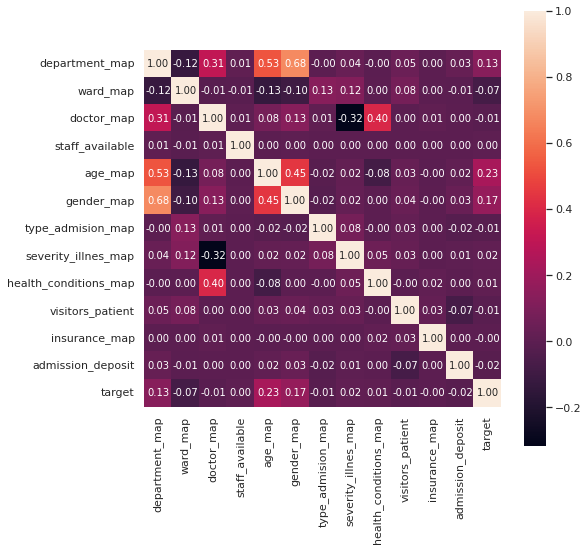

In [95]:
import matplotlib.colors
corr = model_data_final.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10},
           xticklabels= model_data_final.columns, 
           yticklabels= model_data_final.columns,
           #vmin=(corr.min()).min(), vmax=1,
           #center=0,
           cmap= 'rocket')
plt.show()

#Analysis:
We see in the correlation heatmap that Age and Gender are correlated, but this could be a spurious correlation because in the practice the gender is not correlated with age.

In addition, Doctor, the number of visitors per patient, whether the patient has insurance and admission deposit have the lowest correlation to the target.

From all the features, the ones with the highest correlation are Department, Ward facility, age and gender, but we must note these correlations are not too strong

Verifying there are no duplicates in the dataset for model:

In [26]:
X.duplicated().sum()

0

According to the correlation heatmap, I consider that there are not features with strong correlation and should be drooped.

Now on to the model: Logistic Regression from scikit learn. Split the data available and run a cross validation, evaluate and test it:

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
model_log = LogisticRegression(max_iter=150 )    #The model stops itself at an early step, so max_iter=150 is set because by default it's max_iter= 100
model_log.fit(X_train,y_train)

LogisticRegression(max_iter=150)

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

y_pred = model_log.predict(X_test)
print('accuracy and recall of model:', accuracy_score(y_test, y_pred), recall_score(y_test, y_pred) )

accuracy and recall of model: 0.599959349593496 0.8592817109337235


Now I'll predict in the desired values (evalution dataset):

In [29]:
model_log_eval = model_log.predict(X_eval)
predict1_log = pd.DataFrame(np.array(model_log_eval), columns=['pred'])
predict1_log.to_csv("Astroprogramm.csv", index=False)
predict1_log

,pred
0,1
1,1
2,1
3,1
4,1
...,...
89995,0
89996,1
89997,1
89998,1


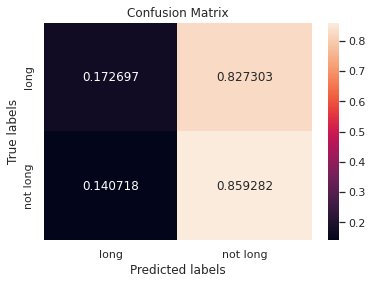

In [109]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, y_pred, normalize= 'true')
   

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['long', 'not long']); ax.yaxis.set_ticklabels(['long', 'not long']);

This model returned an accuracy of 0.5997 and a recall of 0.6315 and with the information taken from the confusion matrix the model must be enhanced.

I'm going to drop more columns since there are some that could be correlated, and so many features could be given noise to the model.

For example, `'department_map'` and`'ward_map'` could be correlated because the department that the patient is admitted and the type of facility will be closely related.

The columns `'visitors_patient'`, `'insurance_map'`, `'admission_deposit'` have the lowest correlation with the target, so it will be drooped as well.

In [114]:
X_2= X.drop(columns=['ward_map','visitors_patient','insurance_map','admission_deposit'])
X_eval_2 = X_eval.drop(columns=['ward_map','visitors_patient','insurance_map','admission_deposit'])
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size=0.30, random_state=42)
model_log2 = LogisticRegression(max_iter=150 )    #The model stops itself at an early step, so max_iter=150 is set because by default it's max_iter= 100
model_log2.fit(X_train_2,y_train)

y_pred_log_2 = model_log2.predict(X_test_2)
print('accuracy and recall of model:', accuracy_score(y_test, y_pred_log_2), recall_score(y_test, y_pred_log_2) )

accuracy and recall of model: 0.5944878048780488 0.8477195824569196


We can see that the accuracy and recall are almost the same, they got a little lower 😂

I'm going to test a new model: Decision Tree Classifier, and first I'll review the maximum depth that best suits this problem at hand

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from IPython.display import clear_output

In [31]:
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,20,1)
i = 0
i_max = len(profundidades)
for profundidad in profundidades:
    i = i + 1
    model = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(model, X_train, y_train, cv=5, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())
    
    clear_output(wait=True)
    print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)

Completado: 100.0%


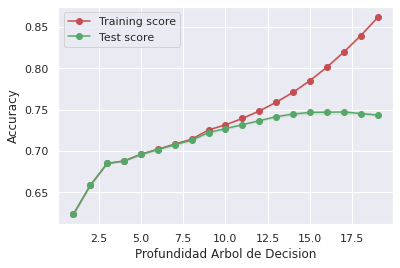

In [32]:
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad Arbol de Decision')
plt.show()

We see that approximately at a max_depth of 11 the model has the best performance with good accuracy and low overfitting

In [35]:
model_tree = DecisionTreeClassifier(max_depth=11)

model_tree.fit(X_train,y_train)
y_pred_tree = model_tree.predict(X_test)
print('accuracy and recall of model:', accuracy_score(y_test, y_pred_tree), recall_score(y_test, y_pred_tree) )

accuracy and recall of model: 0.7324552845528455 0.8086304430189567


Now I will run this model again with fewer features (discussed before in the Logistic Regression model)

In [115]:
model_tree_2 = DecisionTreeClassifier(max_depth=11)

model_tree_2.fit(X_train_2,y_train)
y_pred_tree_2 = model_tree_2.predict(X_test_2)
print('accuracy and recall of model:', accuracy_score(y_test, y_pred_tree_2), recall_score(y_test, y_pred_tree_2) )

accuracy and recall of model: 0.6864715447154471 0.9527455155925427


Now I'll predict in the desired values (evalution dataset):

In [116]:
model_tree_eval_2 = model_tree_2.predict(X_eval_2)
predict4 = pd.DataFrame(np.array(model_tree_eval_2), columns=['pred'])
predict4.to_csv("Astroprogramm.csv", index=False)
predict4

,pred
0,1
1,1
2,1
3,1
4,1
...,...
89995,0
89996,1
89997,1
89998,1


https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf

In [ ]:
import tensorflow
!pip install scikeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_train.shape

(287000, 12)

In [119]:
# modules
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [120]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X_train,y,callbacks=[es],
                    epochs=20, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22960/22960 [==============================] - 46s 2ms/step - loss: 1.2123 - accuracy: 0.5379 - val_loss: 1.3012 - val_accuracy: 0.6210
Epoch 2/20
22960/22960 [==============================] - 45s 2ms/step - loss: 0.8691 - accuracy: 0.5487 - val_loss: 0.6843 - val_accuracy: 0.6010
Epoch 3/20
22960/22960 [====

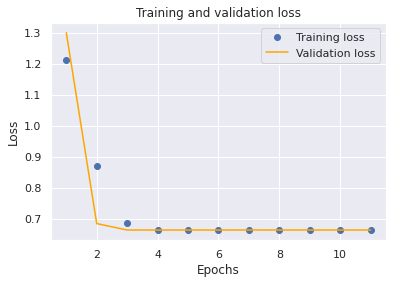

In [121]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [ ]:
y_pred_neural = np.round(model.predict(X_test),0)
print('accuracy and recall of model:', accuracy_score(y_test, y_pred_neural), recall_score(y_test, y_pred_neural) )

3844/3844 [==============================] - 6s 2ms/step
accuracy and recall of model: 0.6223008130081301 1.0


Now I'll predict in the desired values (evalution dataset):

In [ ]:
model_neural = np.round(model.predict(X_eval),0).astype('int')
predict3 = pd.DataFrame(np.array(model_neural), columns=['pred'])
predict3.to_csv("Astroprogramm.csv", index=False)
predict3

2813/2813 [==============================] - 3s 1ms/step


,pred
0,1
1,1
2,1
3,1
4,1
...,...
89995,1
89996,1
89997,1
89998,1


In [ ]:
np.unique(predict3)

array([1.], dtype=float32)

The model is not well tuned yet :p

https://towardsdatascience.com/5-effective-ways-to-improve-the-accuracy-of-your-machine-learning-models-f1ea1f2b5d65

In [ ]:
'''from sklearn.model_selection import cross_validate

'''

'from sklearn.model_selection import cross_validate\n\n'